In [1]:
import seaborn as sns
sns.set(rc={'axes.facecolor': 'dimgrey', 'grid.color': 'lightgrey'})
import pandas as pd
import torch
import copy
import matplotlib.pyplot as plt

In [49]:
%run utils.ipynb
%run gcn_model.ipynb
%run GAT_model.ipynb

In [3]:
# class 1 is illicit, 2 is licit, unknown is unknown
labels = pd.read_csv("data/elliptic_bitcoin_dataset/elliptic_txs_classes.csv")
edges = pd.read_csv("data/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")
nodes = pd.read_csv("data/elliptic_bitcoin_dataset/elliptic_txs_features.csv", header=None)

In [4]:
indexes = labels.index[labels["class"] != "unknown"].tolist()
labels_new = labels[labels["class"] != "unknown"]
nodes_new =  nodes.take(indexes)
edges_new = edges.loc[edges["txId1"].isin(labels_new["txId"])].loc[edges["txId2"].isin(labels_new["txId"])]
nodes_new.shape, labels_new.shape, edges_new.shape

((46564, 167), (46564, 2), (36624, 2))

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

In [7]:
data, graph_info = time_step_split(nodes_new, edges_new, labels_new, device)
for key in data:
    print(key, len(data[key]))

train 31
val 5
test 13


[Data(x=[2147, 165], edge_index=[2, 1924], y=[2147]),
 Data(x=[1117, 165], edge_index=[2, 858], y=[1117]),
 Data(x=[1279, 165], edge_index=[2, 727], y=[1279]),
 Data(x=[1440, 165], edge_index=[2, 1169], y=[1440]),
 Data(x=[1882, 165], edge_index=[2, 1491], y=[1882]),
 Data(x=[485, 165], edge_index=[2, 209], y=[485]),
 Data(x=[1203, 165], edge_index=[2, 858], y=[1203]),
 Data(x=[1165, 165], edge_index=[2, 1044], y=[1165]),
 Data(x=[778, 165], edge_index=[2, 484], y=[778]),
 Data(x=[972, 165], edge_index=[2, 538], y=[972]),
 Data(x=[696, 165], edge_index=[2, 477], y=[696]),
 Data(x=[506, 165], edge_index=[2, 446], y=[506]),
 Data(x=[809, 165], edge_index=[2, 564], y=[809]),
 Data(x=[417, 165], edge_index=[2, 350], y=[417]),
 Data(x=[618, 165], edge_index=[2, 446], y=[618]),
 Data(x=[530, 165], edge_index=[2, 334], y=[530]),
 Data(x=[811, 165], edge_index=[2, 673], y=[811]),
 Data(x=[389, 165], edge_index=[2, 275], y=[389]),
 Data(x=[745, 165], edge_index=[2, 585], y=[745]),
 Data(x=[900,

In [0]:
GCN = GNN_Example(node_dim=data["train"][0].x.shape[1], edge_dim=1, output_dim=2, hidden_dim=256, n_gnn_layers=3, K=2, dropout_rate=0.1).to(device)

In [ ]:
lr = 1e-3
epochs = 50
# weights for classes
weight = torch.tensor([0.5, 0.5]).to(device)
optimizer = torch.optim.Adam(GCN.parameters(), lr=lr)
loss_fn = torch.nn.NLLLoss(weight)

best_model = None
best_valid_auc = 0
best_result = None
losses = []

for epoch in range(1, 1 + epochs):
    # train with random split
    loss = train(GCN, data['train'], optimizer, loss_fn, device)
    losses.append(loss)
    result = test(GCN, data, device)
    train_acc, val_acc, test_acc, train_auc, val_auc, test_auc = result
    if val_auc > best_valid_auc:
        best_valid_auc = val_auc
        best_model = copy.deepcopy(GCN)
        best_result = [train_acc, val_acc, test_acc, train_auc, val_auc, test_auc]
    if epoch % 10 == 0:
        print('Epoch: {:02},'.format(epoch),
              'Loss:{:.4f}'.format(loss),
              'Train:\n{}\n'.format(train_acc),
              'Train_auc_roc: {}'.format(train_auc),
              '\n\n'
              'Valid:\n{}\n'.format(val_acc),
              'Val_auc_roc: {}'.format(val_auc),
              '\n\n'
              'Test:\n{}\n'.format(test_acc),
              'Test_auc_roc: {}'.format(test_auc),
              '\n'
              )
state = {"net":best_model.state_dict(), "optimizer":optimizer.state_dict()}
torch.save(state, "gcn.pt")

In [ ]:
plt.plot(losses)
plt.show()

In [61]:
GAT = GraphAttentionNetwork(node_dim=data["train"][0].x.shape[1], output_dim=2, hidden_dim=256, n_gnn_layers=1, heads=2, dropout_rate=0.5).to(device)

In [62]:
lr = 1e-3
epochs = 50
# weights for classes
weight = torch.tensor([0.5, 0.5]).to(device)
optimizer = torch.optim.Adam(GAT.parameters(), lr=lr)
loss_fn = torch.nn.NLLLoss(weight)

best_model = None
best_valid_auc = 0
best_result = None
losses = []

for epoch in range(1, 1 + epochs):
    # train with random split
    loss = train(GAT, data['train'], optimizer, loss_fn, device)
    losses.append(loss)
    result = test(GAT, data, device)
    train_acc, val_acc, test_acc, train_auc, val_auc, test_auc = result
    if val_auc > best_valid_auc:
        best_valid_auc = val_auc
        best_model = copy.deepcopy(GAT)
        best_result = [train_acc, val_acc, test_acc, train_auc, val_auc, test_auc]
    if epoch % 10 == 0:
        print('Epoch: {:02},'.format(epoch),
              'Loss:{:.4f}'.format(loss),
              'Train:\n{}\n'.format(train_acc),
              'Train_auc_roc: {}'.format(train_auc),
              '\n\n'
              'Valid:\n{}\n'.format(val_acc),
              'Val_auc_roc: {}'.format(val_auc),
              '\n\n'
              'Test:\n{}\n'.format(test_acc),
              'Test_auc_roc: {}'.format(test_auc),
              '\n'
              )
state = {"net":best_model.state_dict(), "optimizer":optimizer.state_dict()}
torch.save(state, "gat.pt")

Epoch: 10, Loss:0.5869 Train:
                   0           1  accuracy   macro avg  weighted avg
precision   0.470236    0.967953  0.903394    0.719094      0.924154
recall      0.652451    0.911671  0.903394    0.782061      0.903394
f1-score    0.534419    0.938329  0.903394    0.736374      0.910098
support    98.709677  792.096774  0.903394  890.806452    890.806452
 Train_auc_roc: 0.7820612397070115 

Valid:
                    0           1  accuracy    macro avg  weighted avg
precision    0.284272    0.971663  0.798519     0.627967      0.909366
recall       0.797521    0.786546  0.798519     0.792034      0.798519
f1-score     0.406029    0.867709  0.798519     0.636869      0.834086
support    123.400000  942.200000  0.798519  1065.600000   1065.600000
 Val_auc_roc: 0.7920336016220723 

Test:
                   0           1  accuracy    macro avg  weighted avg
precision   0.173718    0.972590  0.730016     0.573154      0.926090
recall      0.624051    0.734004  0.730016   

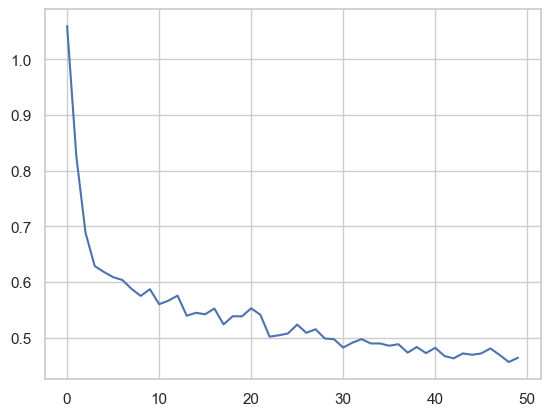

In [63]:
plt.plot(losses)
plt.show()

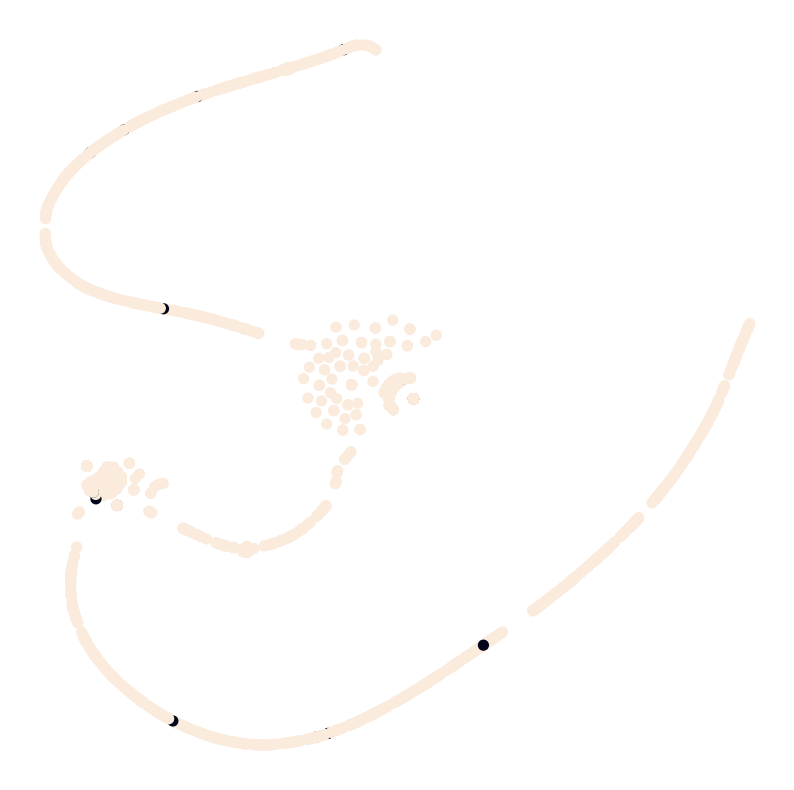

In [64]:
from sklearn.manifold import TSNE

untrained_gat = GraphAttentionNetwork(node_dim=data["train"][0].x.shape[1], output_dim=2, hidden_dim=256, n_gnn_layers=1, heads=2, dropout_rate=0.5).to(device)

# Get embeddings
h = untrained_gat(data["train"][0])

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
            init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data["train"][0].y)
plt.show()

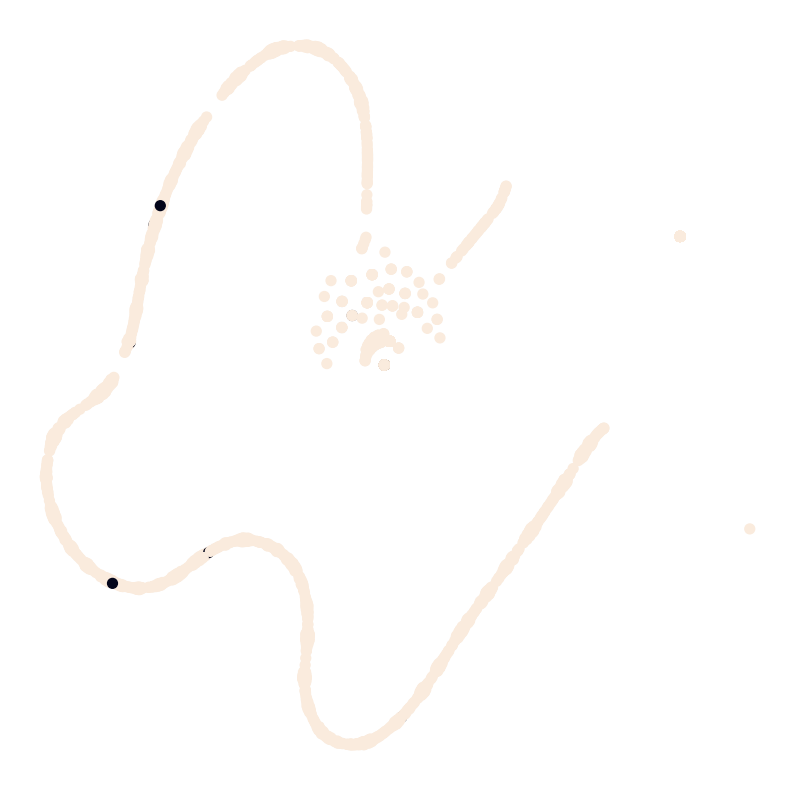

In [66]:
# Get embeddings
checkpoint = torch.load("gat.pt", map_location=device)
GAT = GraphAttentionNetwork(node_dim=data["train"][0].x.shape[1], output_dim=2, hidden_dim=256, n_gnn_layers=1, heads=2, dropout_rate=0.5).to(device)
GAT.load_state_dict(checkpoint["net"])

h = GAT(data["train"][0])

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
            init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data["train"][0].y)
plt.show()